#  &#x1F4D1; 作业6- Generative Adversarial Network
这是台大2022年机器学习课程hw6的样本代码。

在此示例代码中，有5个部分：
1. 环境设置
2. 数据准备
3. 模型设置
4. 模型训练
5. 模型推理

你的目标是做动漫人脸生成，如果你有任何问题，请在NTU COOL讨论 

# 导入包

In [3]:
import os
import glob
import random
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import logging
from tqdm import tqdm

# 环境设置
在本节中，我们将准备数据集并设置一些环境变量

In [5]:
# 设置全局的随机种子
def all_seed(seed = 6666):
    """
    设置随机种子
    """
    np.random.seed(seed)
    random.seed(seed)
    # CPU
    torch.manual_seed(seed) 
    # GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed) 
    # python 全局
    os.environ['PYTHONHASHSEED'] = str(seed) 
    # cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    print(f'Set env random_seed = {seed}')
    
all_seed(2022)
workspace_dir = r'./faces'

Set env random_seed = 2022


# 数据准备
在本节中，我们准备Pytorch的数据集

## 数据下载

In [8]:
# 从huggingface hub下载数据
# !curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | bash
# !apt-get install git-lfs
# !git lfs install
# !git clone https://huggingface.co/datasets/LeoFeng/MLHW_6
# !unzip ./MLHW_6/faces.zip -d .



## 创建Pytorch数据集

为了统一图像信息，我们使用变换函数：
1. 图片大小转换成 64x64
2. 图片进行Normalize

此CrypkoDataset类将在第4节中使用

In [10]:
class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        img = torchvision.io.read_image(fname)
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples


def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

## 数据查看
查看图片

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


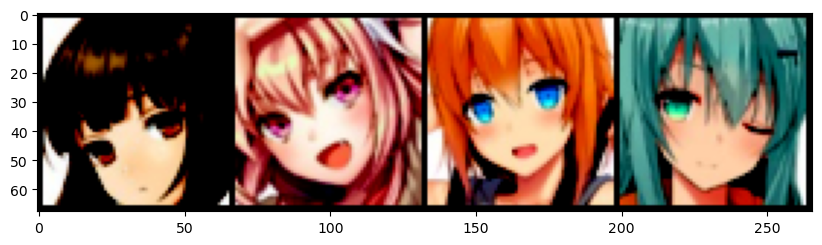

In [12]:
temp_dataset = get_dataset(os.path.join(workspace_dir, 'faces'))

images = [temp_dataset[i] for i in range(4)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

#  &#x2728; 模型设置
在本节中，我们将创建模型和trainer进行模型训练。

In [14]:
# 生成器
class Generator(nn.Module):
    """
    Input shape: (batch, in_dim)
    Output shape: (batch, 3, 64, 64)
    """
    def __init__(self, in_dim, feature_dim=64):
        super(Generator, self).__init__()
    
        #input: 输入随机一维向量 (batch, 100) 随机生成噪点数据 -> (batch, 64 * 8 * 4 * 4)
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, feature_dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(feature_dim * 8 * 4 * 4),
            nn.ReLU()
        )
        # y.view(y.size(0), -1, 4, 4) -> 转成 (batch, feature_dim * 8, 4, 4)
        # 上采样并提取特征：逐步将channel中的特征信息转到 height and width 维度
        self.l2 = nn.Sequential(
            self.dconv_bn_relu(feature_dim * 8, feature_dim * 4),               # out_put -> (batch, feature_dim * 4, 8, 8)     
            self.dconv_bn_relu(feature_dim * 4, feature_dim * 2),               # out_put -> (batch, feature_dim * 2, 16, 16)     
            self.dconv_bn_relu(feature_dim * 2, feature_dim),                   # out_put -> (batch, feature_dim, 32, 32)     
        )
        # out_put -> (batch, 3, 64, 64) channel dim=1
        self.l3 = nn.Sequential(
            nn.ConvTranspose2d(feature_dim, 3, kernel_size=5, stride=2,
                               padding=2, output_padding=1, bias=False),
            nn.Tanh()   
        )
        self.apply(weights_init)

    def dconv_bn_relu(self, in_dim, out_dim):
        return nn.Sequential(
            nn.ConvTranspose2d(in_dim, out_dim, kernel_size=5, stride=2,
                               padding=2, output_padding=1, bias=False),        # 双倍 height and width
            nn.BatchNorm2d(out_dim),
            nn.ReLU(True)
        )

    def forward(self, x):
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2(y)
        y = self.l3(y)
        return y

In [15]:
# Discriminator: 判别器  生成img 和 真实img
class Discriminator(nn.Module):
    """
    输入: (batch, 3, 64, 64)
    输出: (batch)
    """
    def __init__(self, in_dim, feature_dim=64):
        super(Discriminator, self).__init__()
            
        # input: (batch, 3, 64, 64)
        """
        设置Discriminator的注意事项:
            在WGAN中需要移除最后一层 sigmoid
        """
        self.l1 = nn.Sequential(
            nn.Conv2d(in_dim, feature_dim, kernel_size=4, stride=2, padding=1), # output -> (batch, 64, 32, 32)
            nn.LeakyReLU(0.2),
            self.conv_bn_lrelu(feature_dim, feature_dim * 2),                   # output -> (batch, 128, 32, 32)
            self.conv_bn_lrelu(feature_dim * 2, feature_dim * 4),               # output -> (batch, 256, 32, 32)
            self.conv_bn_lrelu(feature_dim * 4, feature_dim * 8),               # output -> (batch, 512, 32, 32)
            nn.Conv2d(feature_dim * 8, 1, kernel_size=4, stride=1, padding=0),  # output -> (batch, 1, 1, 1)
            nn.Sigmoid() 
        )
        self.apply(weights_init)
        
    def conv_bn_lrelu(self, in_dim, out_dim):
        """
        设置Discriminator的注意事项:
            在WGAN-GP中不能使用 nn.Batchnorm， 需要使用 nn.InstanceNorm2d 替代
        """
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, 4, 2, 1),
            nn.BatchNorm2d(out_dim),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        y = self.l1(x)
        y = y.view(-1)
        return y


In [16]:
# 网络权重初始化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

## &#x2728; 创建训练pipeline `TrainerGAN`
在本节中，我们将创建一个包含以下功能的训练器：
1. `prepare_environment`: 准备整个环境，构建模型，为日志和ckpt创建目录
2. `train`: 为生成器（generator）和判别器（discriminator）进行训练，可以尝试修改此处的代码来构造 WGAN或WGAN-GP
3. `inference`: 训练后，可以将生成器（generator）ckpt路径传递到其中，函数会生成图片并保存结果

In [18]:
class TrainerGAN():
    def __init__(self, config):
        self.config = config
        
        self.G = Generator(100)
        self.D = Discriminator(3)
        
        self.loss = nn.BCELoss()

        """
        优化器设置注意：
            GAN: 使用 Adam optimizer
            WGAN: 使用 RMSprop optimizer
            WGAN-GP: 使用 Adam optimizer 
        """
        self.opt_D = torch.optim.Adam(self.D.parameters(), lr=self.config["lr"], betas=(0.5, 0.999))
        self.opt_G = torch.optim.Adam(self.G.parameters(), lr=self.config["lr"], betas=(0.5, 0.999))
        
        self.dataloader = None
        self.log_dir = os.path.join(self.config["workspace_dir"], 'logs')
        self.ckpt_dir = os.path.join(self.config["workspace_dir"], 'checkpoints')
        
        FORMAT = '%(asctime)s - %(levelname)s: %(message)s'
        logging.basicConfig(level=logging.INFO, 
                            format=FORMAT,
                            datefmt='%Y-%m-%d %H:%M')
        
        self.steps = 0
        self.z_samples = Variable(torch.randn(100, self.config["z_dim"])).cuda()
        
    def prepare_environment(self):
        """
        训练前环境、数据与模型准备
        """
        os.makedirs(self.log_dir, exist_ok=True)
        os.makedirs(self.ckpt_dir, exist_ok=True)
        
        # 基于时间更新日志和ckpt文件名
        time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        self.log_dir = os.path.join(self.log_dir, time+f'_{self.config["model_type"]}')
        self.ckpt_dir = os.path.join(self.ckpt_dir, time+f'_{self.config["model_type"]}')
        os.makedirs(self.log_dir)
        os.makedirs(self.ckpt_dir)
        
        # 数据准备：创建dataloader
        dataset = get_dataset(os.path.join(self.config["workspace_dir"], 'faces'))
        self.dataloader = DataLoader(dataset, batch_size=self.config["batch_size"], shuffle=True, num_workers=2)
        
        # 模型准备
        self.G = self.G.cuda()
        self.D = self.D.cuda()
        self.G.train()
        self.D.train()
        
    def gp(self):
        """
        实现梯度惩罚功能
        """
        pass
        
    def train(self):
        """
        训练 generator 和 discriminator
        """
        self.prepare_environment()
        
        for e, epoch in enumerate(range(self.config["n_epoch"])):
            progress_bar = tqdm(self.dataloader)
            progress_bar.set_description(f"Epoch {e+1}")
            for i, data in enumerate(progress_bar):
                imgs = data.cuda()
                bs = imgs.size(0)

                # *********************
                # *    Train D-判别器  *
                # *********************
                z = Variable(torch.randn(bs, self.config["z_dim"])).cuda()
                r_imgs = Variable(imgs).cuda()
                # 生成器生成假照片
                f_imgs = self.G(z)
                r_label = torch.ones((bs)).cuda()
                f_label = torch.zeros((bs)).cuda()


                # Discriminator前向传播
                r_logit = self.D(r_imgs)
                f_logit = self.D(f_imgs)

                """
                DISCRIMINATOR损失设置注意:
                    GAN:  loss_D = (r_loss + f_loss)/2
                    WGAN: loss_D = -torch.mean(r_logit) + torch.mean(f_logit)
                    WGAN-GP:
                        gradient_penalty = self.gp(r_imgs, f_imgs)
                        loss_D = -torch.mean(r_logit) + torch.mean(f_logit) + gradient_penalty
                """
                # discriminator的损失: (评估 是否能区分真实图片和生成图片)
                #    生成fake->判别logit VS 0    &  real->判别logit VS 1 
                r_loss = self.loss(r_logit, r_label)
                f_loss = self.loss(f_logit, f_label)
                loss_D = (r_loss + f_loss) / 2

                # Discriminator 反向传播
                self.D.zero_grad()
                loss_D.backward()
                self.opt_D.step()

                """
                设置 WEIGHT CLIP 注意:
                    WGAN: 使用以下code
                """
                # for p in self.D.parameters():
                #     p.data.clamp_(-self.config["clip_value"], self.config["clip_value"])

                # *********************
                # *    Train G-生成器  *
                # *********************
                if self.steps % self.config["n_critic"] == 0:
                    # 生成一些假照片
                    z = Variable(torch.randn(bs, self.config["z_dim"])).cuda()
                    f_imgs = self.G(z)

                    # Generator前向传播
                    f_logit = self.D(f_imgs)

                    """
                    生成器损失函数设置注意：
                        GAN: loss_G = self.loss(f_logit, r_label)
                        WGAN: loss_G = -torch.mean(self.D(f_imgs))
                        WGAN-GP: loss_G = -torch.mean(self.D(f_imgs))
                    """
                    # 生成器损失(评估 生成图片和真实 是否很接近): 生成->判别logit VS 1
                    loss_G = self.loss(f_logit, r_label)

                    # Generator反向传播
                    self.G.zero_grad()
                    loss_G.backward()
                    self.opt_G.step()
                    
                if self.steps % 10 == 0:
                    progress_bar.set_postfix(loss_G=loss_G.item(), loss_D=loss_D.item())
                self.steps += 1

            self.G.eval()
            f_imgs_sample = (self.G(self.z_samples).data + 1) / 2.0
            filename = os.path.join(self.log_dir, f'Epoch_{epoch+1:03d}.jpg')
            torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
            logging.info(f'Save some samples to {filename}.')

            # 在训练过程中显示图片
            grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
            plt.figure(figsize=(10,10))
            plt.imshow(grid_img.permute(1, 2, 0))
            plt.show()

            self.G.train()

            if (e+1) % 5 == 0 or e == 0:
                # 保存checkpoints.
                torch.save(self.G.state_dict(), os.path.join(self.ckpt_dir, f'G_{e}.pth'))
                torch.save(self.D.state_dict(), os.path.join(self.ckpt_dir, f'D_{e}.pth'))

        logging.info('Finish training')

    def inference(self, G_path, n_generate=1000, n_output=30, show=False):
        """
        1. G_path： 生成器ckpt路径
        2. 可以使用此函数生成最终答案
        """

        self.G.load_state_dict(torch.load(G_path))
        self.G.cuda()
        self.G.eval()
        z = Variable(torch.randn(n_generate, self.config["z_dim"])).cuda()
        imgs = (self.G(z).data + 1) / 2.0
        
        os.makedirs('output', exist_ok=True)
        for i in range(n_generate):
            torchvision.utils.save_image(imgs[i], f'output/{i+1}.jpg')
        
        if show:
            row, col = n_output//10 + 1, 10
            grid_img = torchvision.utils.make_grid(imgs[:n_output].cpu(), nrow=row)
            plt.figure(figsize=(row, col))
            plt.imshow(grid_img.permute(1, 2, 0))
            plt.show()

# &#x2728;模型训练
在本节中，我们将首先设置训练器的配置，然后使用它来训练生成器（generator）和判别器（discriminator）

In [20]:
config = {
    "model_type": "GAN",
    "batch_size": 64,
    "lr": 1e-4,
    "n_epoch": 5,
    "n_critic": 1,
    "z_dim": 100,
    "workspace_dir": workspace_dir, 
}

## 开始训练

In [ ]:
trainer = TrainerGAN(config)
trainer.train()

Epoch 1:   0%|                                                                                                                                                                | 0/808 [00:00<?, ?it/s]

# 模型推理 `Inference`

In [ ]:
# save the 1000 images into ./output folder
# trainer.inference(f'{workspace_dir}/checkpoints/2022-03-31_15-59-17_GAN/G_0.pth') # 需要改用相应的生成器的路径